# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

Содержание:

1. [Изучаем данные](#the_destination01)
    - 1.1 [Загружаем данные и библиотеки](#the_destination01.1)
    - 1.2 [Признаки, недоступные в тестовой выборке](#the_destination01.2)
    - 1.3 [Эффективность обогащения посчитана правильно?](#the_destination01.3)
    
2. [Анализ данных](#the_destination02)
    - 2.1 [Как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки](#the_destination02.1)
    - 2.2 [Сравнение распределения размеров гранул сырья](#the_destination02.2)
    - 2.3 [Суммарная концентрация веществ](#the_destination02.3)
    
3. [Прогноз rougher.recovery](#the_destination03)
    - 3.1 [Подготовка данных](#the_destination03.1)
    - 3.2 [Поиск оптимальной модели](#the_destination03.2)

4. [Прогноз final.recovery](#the_destination04)
    - 4.1 [Подготовка данных](#the_destination04.1)
    - 4.2 [Поиск оптимальной модели](#the_destination04.2)
    
5. [Вывод](#the_destination05)

# 1. Подготовка данных <a id='the_destination01'></a>

## 1.1 Загружаем данные и библиотеки <a id='the_destination01.1'></a>

In [145]:
import pandas as pd
import numpy as np

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kruskal

train = pd.read_csv('/datasets/gold_recovery_train.csv')
test = pd.read_csv('/datasets/gold_recovery_test.csv')
full = pd.read_csv('/datasets/gold_recovery_full.csv')

state = np.random.RandomState(21)
sns.set()

Старая функция `column_info` показывает информацию по столбцу.

In [146]:
def column_info(data, column, quantitative=False, mean=True, median=True, hist=True, bins=50):    
    lost = data[column].isna().sum() #смотрим количество пропусков
    total = data.shape[0] #длина всех значений переменной
    print()
    print('*** Информация по столбцу {} ***'.format(column))
    print()
    print('Тип данных столбца {}: {}:'.format(column, data[column].dtype))
    print('В столбце {} пропущено {} из {} строк, что составляет {:.2%}'
          .format(column, lost, total, lost / total)) #считаем процент пропусков
    if quantitative:        
        print('Минимальное значение: {:.2f}'.format(data[column].min()))
        print('Максимальное значение: {:.2f}'.format(data[column].max()))
        if mean:
            print('Среднее значение: {:.2f}'.format(data[column].mean()))
        if median:
            print('Медианное значение: {:.2f}'.format(data[column].median()))
        if hist:
            gridsize = (5, 1)
            fig = plt.figure(figsize=(15, 5))
            ax1 = plt.subplot2grid(gridsize, (0, 0))
            ax2 = plt.subplot2grid(gridsize, (1, 0), rowspan=4)                       
            sns.boxplot(data[column], ax=ax1)            
            sns.distplot(data[column], kde=False, bins=bins, ax=ax2)            
            ax1.get_xaxis().set_visible(False)            
            plt.show()                        
    else:
        print()
        print('Количество значений в каждой из категорий:')
        print(data[column].value_counts())        
    print()

Функция `bar_chart` выводит информацию с помощью баров в минималистичном виде.

In [147]:
def bar_chart(array, column_names, title, color='teal', figsize=(6,4)):
    plt.figure(figsize=figsize)    
    n = len(array)
    
    bars = plt.bar(np.arange(n), array, color=color)
    
    for bar in bars:
        height = bar.get_height()
        plt.gca().text(bar.get_x() + bar.get_width()/2, height*.90, '{0:.{1}f}'.format(height, 2), 
                     ha='center', color='w', fontsize=11)

    plt.tick_params(which='both', bottom=False, top=False, left=False, right=False, labelbottom=True) 
    
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    plt.xticks(range(n), column_names, alpha=0.8);
    plt.title(title, alpha=0.8)

Годится ли переменная `date` на роль индекса?

In [148]:
train['date'].duplicated().any()

False

In [149]:
test['date'].duplicated().any()

False

In [150]:
full['date'].duplicated().any()

False

Мы видим, что для каждой выборки значения для строк `date` уникальны.

In [151]:
len(np.intersect1d(train['date'], test['date']))

0

Смотрим, есть ли одинаковые значения `date` в df `train` и `test`. Их нет.

In [152]:
len(np.intersect1d(train['date'], full['date'])) == len(train)

True

Все ли значения `date` из `train` присутствуют в `full`? Все.

In [153]:
len(np.intersect1d(test['date'], full['date'])) == len(test)

True

Все ли значения `date` из `test` присутствуют в `full`? Все.

**Вывод** Столбец `date` годится в качестве индекса.

Переводим даты в соответствующий формат и устанавливаем в качестве индексов `date`:

In [154]:
train['date'] = pd.to_datetime(train['date'], format='%Y-%m-%d %H:%M:%S')
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d %H:%M:%S')
full['date'] = pd.to_datetime(full['date'], format='%Y-%m-%d %H:%M:%S')
train.set_index('date', inplace=True)
test.set_index('date', inplace=True)
full.set_index('date', inplace=True)

## 1.2 Признаки, недоступные в тестовой выборке <a id='the_destination01.2'></a>

Какие переменные отсутствуют в test, которые есть в train?

In [155]:
difference_vars = [i for i in train.columns.to_list() if i not in test.columns.to_list()]
difference_vars

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

**Вывод** Эти параметры получаются в результате вычислений и результат действия процессов. То есть, чтобы не было утечек обучающей выборке их видеть не надо.

Запоминаем обучающие переменные:

In [156]:
features_var = test.columns

Возьмём из `full` переменные для `test`:

In [157]:
test = test.join(full[difference_vars])

In [158]:
test.shape

(5856, 86)

In [159]:
print('Процент пропущенных значений в train: {:.2%}'.format(train.isna().sum().sum() / (train.shape[0] * train.shape[1])))
train.fillna(full, inplace=True)
print('Процент пропущенных значений в train: {:.2%}'.format(train.isna().sum().sum() / (train.shape[0] * train.shape[1])))
print()
print('Процент пропущенных значений в test: {:.2%}'.format(test.isna().sum().sum() / (test.shape[0] * test.shape[1])))
test.fillna(full, inplace=True)
print('Процент пропущенных значений в test: {:.2%}'.format(test.isna().sum().sum() / (test.shape[0] * test.shape[1])))

Процент пропущенных значений в train: 2.09%
Процент пропущенных значений в train: 2.09%

Процент пропущенных значений в test: 1.24%
Процент пропущенных значений в test: 1.24%


**Вывод** Заполнение пропущенных значений в `train` и `test` из `full` никак не помогло.

## 1.3 Эффективность обогащения посчитана правильно? <a id='the_destination01.3'></a>

Функция `recovery_calculation` вычисляет значение бизнес-метрики `recovery` для каждой отдельной строчки.

In [160]:
def recovery_calculation(row):    
    c = row['rougher.output.concentrate_au'] / 100
    f = row['rougher.input.feed_au'] / 100
    t = row['rougher.output.tail_au'] / 100
        
    if f * (c - t) != 0:
        recovery = c * (f - t) / (f * (c - t)) * 100
        row['rougher.output.recovery_check'] = recovery
    else:
        row['rougher.output.recovery_check'] = np.nan 
    
    return row

Вычисляем `recovery` в соответствии с формулой и проверяем, соответствует ли оно уже предоставленному метрикой `mae`.

In [161]:
train = train.apply(recovery_calculation, axis=1)
train_for_mean = train[train['rougher.output.recovery'].notna() & train['rougher.output.recovery_check'].notna()]
mean_absolute_error(train_for_mean['rougher.output.recovery'], train_for_mean['rougher.output.recovery_check'])

1.2610383561665586e-14

**Вывод** Данные по `recovery` в `rougher` df `train` предоставлены корректно.

# 2. Анализ данных <a id='the_destination02'></a>

## 2.1 Как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки <a id='the_destination02.1'></a>

Смотрим как меняется концентразия `au` на разных этапах процесса.

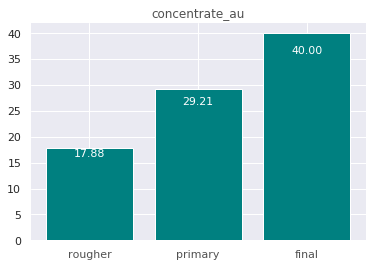

In [162]:
data = [full['rougher.output.concentrate_au'].mean(),
        full['primary_cleaner.output.concentrate_au'].mean(),
        full['final.output.concentrate_au'].mean()
       ]
column_names = ['rougher', 'primary', 'final']

bar_chart(data, column_names, 'concentrate_au')

**Вывод** Концентрация золота увеличивается, для этого всё и делается.

Смотрим как меняется концентразия `ag` на разных этапах процесса.

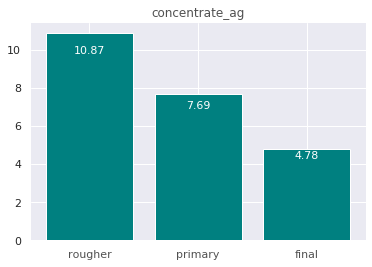

In [163]:
data = [full['rougher.output.concentrate_ag'].mean(),
        full['primary_cleaner.output.concentrate_ag'].mean(),
        full['final.output.concentrate_ag'].mean()
       ]
column_names = ['rougher', 'primary', 'final']

bar_chart(data, column_names, 'concentrate_ag')

**Вывод** Концентрация серебра уменьшается, так как мы стремимся получить золото.

Смотрим как меняется концентразия `pb` на разных этапах процесса.

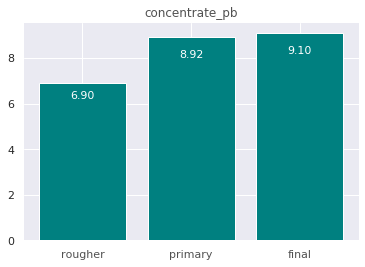

In [164]:
data = [full['rougher.output.concentrate_pb'].mean(),
        full['primary_cleaner.output.concentrate_pb'].mean(),
        full['final.output.concentrate_pb'].mean()
       ]

column_names = ['rougher', 'primary', 'final']

bar_chart(data, column_names, 'concentrate_pb')

**Вывод** Концентрация свинца увеличивается, но не сильно. Наверное, это не очень хорошо для процесса, но неизбежно.

## 2.2 Сравнение распределения размеров гранул сырья <a id='the_destination02.2'></a>

Фунция `single_trimmer` избавляется от выбросов в смысле `boxplot`. Нужно нам это затем, чтобы точнее оценить распределения.

In [165]:
def single_trimmer(array, k=1.5):    
    left_quantile = np.quantile(array, 0.25)
    right_quantile = np.quantile(array, 0.75)
    left_whisker = left_quantile - k * (right_quantile - left_quantile)
    right_whisker = right_quantile + k * (right_quantile - left_quantile)
    return array[(array >= left_whisker) & (array <= right_whisker)]

Формируем распределения без пропусков и выбросов.

In [166]:
train_distr = single_trimmer(train['rougher.input.feed_size'].dropna())
test_distr = single_trimmer(test['rougher.input.feed_size'].dropna())

**Вывод** Как мы видим, визуально они заметно отличаются при этом не сильно похожи на нормальные.

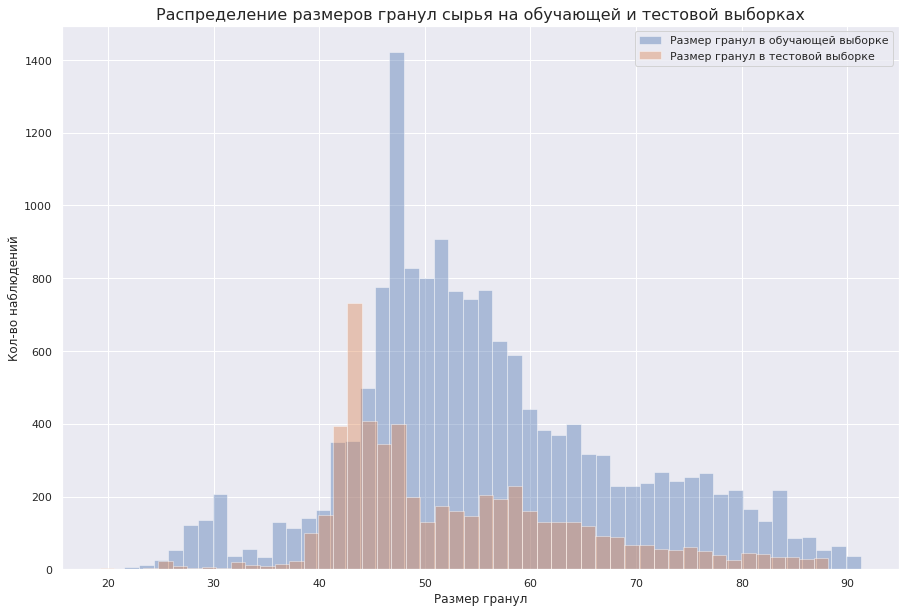

In [167]:
plt.figure(figsize=(15, 10))
sns.distplot(train_distr, bins=50, kde=False, label='Размер гранул в обучающей выборке')
sns.distplot(test_distr, bins=50, kde=False, label='Размер гранул в тестовой выборке')
plt.title('Распределение размеров гранул сырья на обучающей и тестовой выборках', fontsize=16)
plt.xlabel('Размер гранул')
plt.ylabel('Кол-во наблюдений')
plt.legend()
plt.show()

In [168]:
print('Средний размер гранулы в train: {:.2f}'.format(train['rougher.input.feed_size'].mean()))
print('Средний размер гранулы в train: {:.2f}'.format(test['rougher.input.feed_size'].mean()))

Средний размер гранулы в train: 58.68
Средний размер гранулы в train: 55.94


**Вывод** А вот средние разметры гранул отличаются незначительно.

Для того, чтобы ответить на вопрос, из одной генеральной совокупности взяты эти две выборки, воспользуемся критерием Краскела.

In [169]:
results = kruskal(train_distr, test_distr)
print('p-значение: ', results.pvalue)

p-значение:  8.225897693468535e-83


**Вывод** Распределение выборок отличается. Что это значит? Неудачно разбили `full` на `train` и `test`. По-хорошему, нужно ещё раз с помощью `train_test_split` сделать это. Но у нас выборки уже готовы. Будем работать с тем, что дают. Как будет видно ниже, на результатах это сильно не сказалось.

## 2.3 Суммарная концентрация веществ <a id='the_destination02.3'></a>

Суммарная концентрация всех веществ в на стадии `rougher` в выборке `train`.


*** Информация по столбцу rougher.output.concentrate_sum ***

Тип данных столбца rougher.output.concentrate_sum: float64:
В столбце rougher.output.concentrate_sum пропущено 162 из 16860 строк, что составляет 0.96%
Минимальное значение: 0.00
Максимальное значение: 90.96
Среднее значение: 60.31
Медианное значение: 68.41


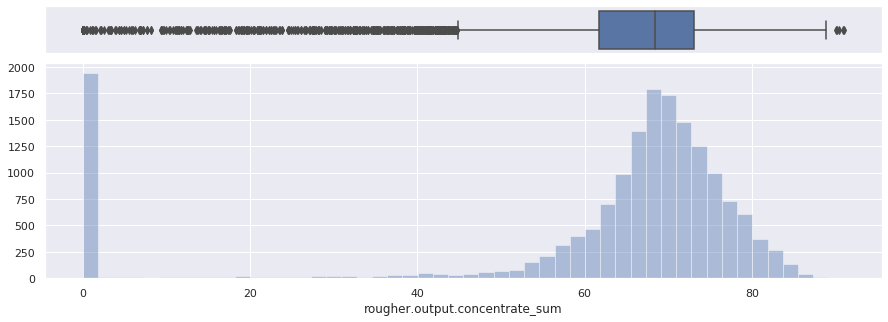

In [170]:
train['rougher.output.concentrate_sum'] = (train['rougher.output.concentrate_ag'] + 
                                           train['rougher.output.concentrate_pb'] + 
                                           train['rougher.output.concentrate_sol'] + 
                                           train['rougher.output.concentrate_au']
                                          )

column_info(train, 'rougher.output.concentrate_sum', quantitative=True)

Суммарная концентрация всех веществ в на стадии `primary_cleaner` в выборке `train`.


*** Информация по столбцу primary_cleaner.output.concentrate_sum ***

Тип данных столбца primary_cleaner.output.concentrate_sum: float64:
В столбце primary_cleaner.output.concentrate_sum пропущено 636 из 16860 строк, что составляет 3.77%
Минимальное значение: 0.00
Максимальное значение: 76.92
Среднее значение: 54.44
Медианное значение: 61.28


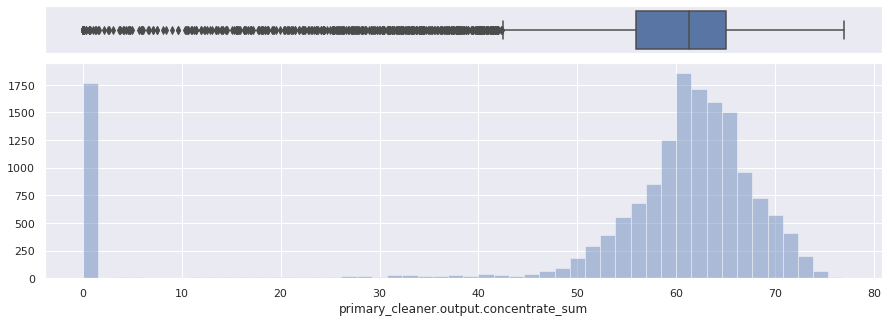

In [171]:
train['primary_cleaner.output.concentrate_sum'] = (train['primary_cleaner.output.concentrate_ag'] + 
                                                   train['primary_cleaner.output.concentrate_pb'] + 
                                                   train['primary_cleaner.output.concentrate_sol'] + 
                                                   train['primary_cleaner.output.concentrate_au']
                                                  )

column_info(train, 'primary_cleaner.output.concentrate_sum', quantitative=True)

Суммарная концентрация всех веществ в на стадии `final` в выборке `train`.


*** Информация по столбцу final.output.concentrate_sum ***

Тип данных столбца final.output.concentrate_sum: float64:
В столбце final.output.concentrate_sum пропущено 371 из 16860 строк, что составляет 2.20%
Минимальное значение: 0.00
Максимальное значение: 80.21
Среднее значение: 61.52
Медианное значение: 68.86


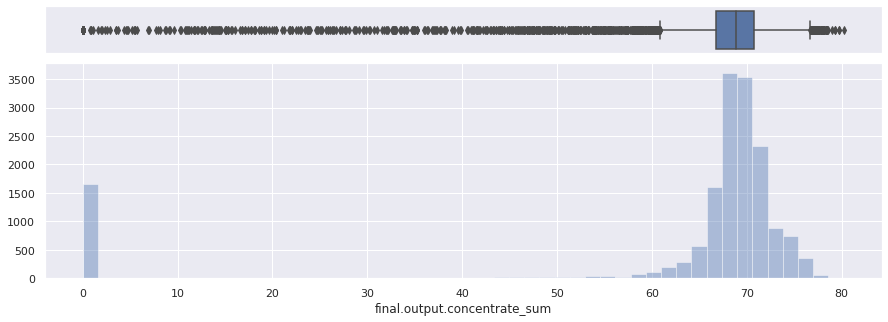

In [172]:
train['final.output.concentrate_sum'] = (train['final.output.concentrate_ag'] + 
                                         train['final.output.concentrate_pb'] + 
                                         train['final.output.concentrate_sol'] + 
                                         train['final.output.concentrate_au']
                                         )

column_info(train, 'final.output.concentrate_sum', quantitative=True)

Суммарная концентрация всех веществ в на стадии `rougher` в выборке `test`.


*** Информация по столбцу rougher.output.concentrate_sum ***

Тип данных столбца rougher.output.concentrate_sum: float64:
В столбце rougher.output.concentrate_sum пропущено 28 из 5856 строк, что составляет 0.48%
Минимальное значение: 0.00
Максимальное значение: 86.39
Среднее значение: 66.08
Медианное значение: 72.20


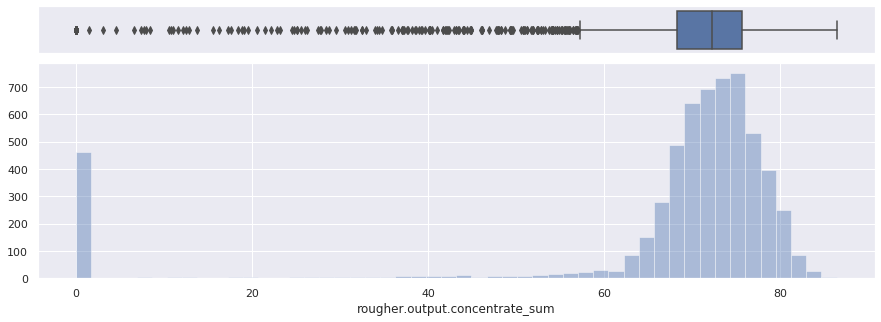

In [173]:
test['rougher.output.concentrate_sum'] = (test['rougher.output.concentrate_ag'] + 
                                          test['rougher.output.concentrate_pb'] + 
                                          test['rougher.output.concentrate_sol'] + 
                                          test['rougher.output.concentrate_au']
                                          )

column_info(test, 'rougher.output.concentrate_sum', quantitative=True)

Суммарная концентрация всех веществ в на стадии `primary_cleaner` в выборке `test`.


*** Информация по столбцу primary_cleaner.output.concentrate_sum ***

Тип данных столбца primary_cleaner.output.concentrate_sum: float64:
В столбце primary_cleaner.output.concentrate_sum пропущено 162 из 5856 строк, что составляет 2.77%
Минимальное значение: 0.00
Максимальное значение: 80.75
Среднее значение: 58.42
Медианное значение: 63.85


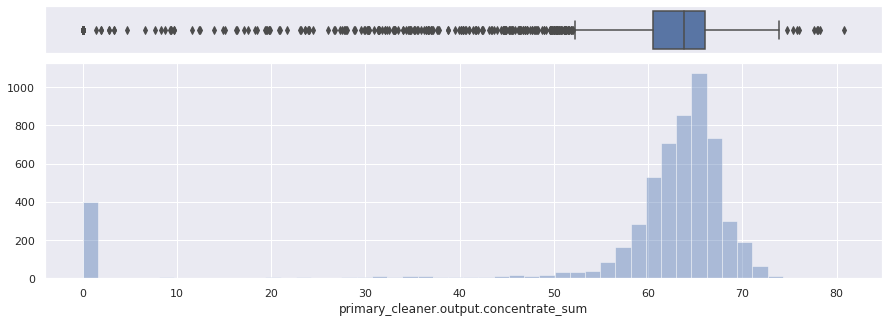

In [174]:
test['primary_cleaner.output.concentrate_sum'] = (test['primary_cleaner.output.concentrate_ag'] + 
                                                  test['primary_cleaner.output.concentrate_pb'] + 
                                                  test['primary_cleaner.output.concentrate_sol'] + 
                                                  test['primary_cleaner.output.concentrate_au']
                                                  )

column_info(test, 'primary_cleaner.output.concentrate_sum', quantitative=True)

Суммарная концентрация всех веществ в на стадии `final` в выборке `test`.


*** Информация по столбцу final.output.concentrate_sum ***

Тип данных столбца final.output.concentrate_sum: float64:
В столбце final.output.concentrate_sum пропущено 17 из 5856 строк, что составляет 0.29%
Минимальное значение: 0.00
Максимальное значение: 79.98
Среднее значение: 65.16
Медианное значение: 70.46


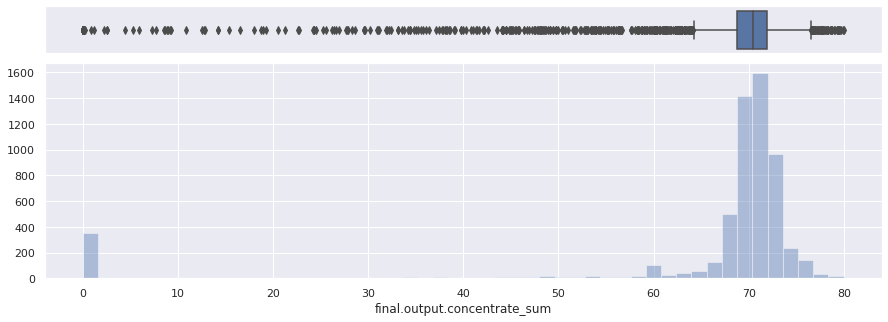

In [175]:
test['final.output.concentrate_sum'] = (test['final.output.concentrate_ag'] + 
                                        test['final.output.concentrate_pb'] + 
                                        test['final.output.concentrate_sol'] + 
                                        test['final.output.concentrate_au']
                                        )

column_info(test, 'final.output.concentrate_sum', quantitative=True)

**Вывод** Удаляем те строки, где концентрация золота в сырье 0, помимо того, что при расчёте `recovery` нам не придётся делить на 0, итак ясно, что если изначально золота в серье не было, то на выходе его ждать не стоит.


*** Информация по столбцу final.output.concentrate_sum ***

Тип данных столбца final.output.concentrate_sum: float64:
В столбце final.output.concentrate_sum пропущено 340 из 15111 строк, что составляет 2.25%
Минимальное значение: 0.04
Максимальное значение: 80.21
Среднее значение: 66.64
Медианное значение: 69.08


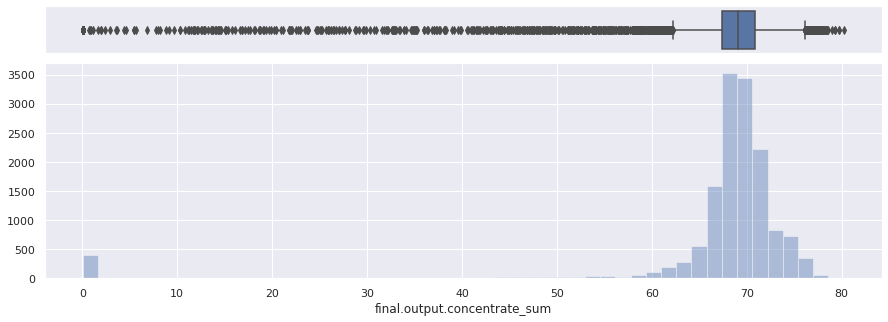

In [176]:
train = train[(train['rougher.output.concentrate_sum'] != 0) & 
              (train['primary_cleaner.output.concentrate_sum'] != 0) &
              (train['final.output.concentrate_sum'] != 0)
             ]

column_info(train, 'final.output.concentrate_sum', quantitative=True)


*** Информация по столбцу final.output.concentrate_sum ***

Тип данных столбца final.output.concentrate_sum: float64:
В столбце final.output.concentrate_sum пропущено 17 из 5278 строк, что составляет 0.32%
Минимальное значение: 0.04
Максимальное значение: 79.98
Среднее значение: 69.59
Медианное значение: 70.68


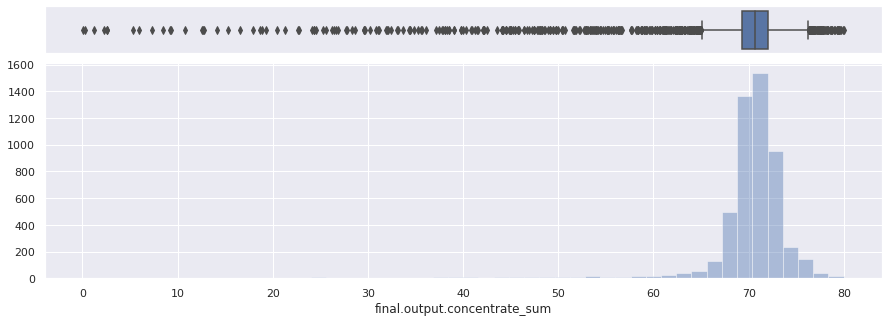

In [177]:
test = test[(test['rougher.output.concentrate_sum'] != 0) & 
            (test['primary_cleaner.output.concentrate_sum'] != 0) &
            (test['final.output.concentrate_sum'] != 0)
           ]

column_info(test, 'final.output.concentrate_sum', quantitative=True)

**Вывод** Теперь выборки `train` и `test` без аномальных значений.

## 3. Прогноз rougher.recovery <a id='the_destination03'></a>

### 3.1 Подготовка данных <a id='the_destination03.1'></a>

In [178]:
train_features = train[features_var]

Оставляем в `train` только переменные из `test`.

Функция `not_very_correlated_features` оставляет только те переменные, которые имеют попарную корреляцию меньше определенного порога.

In [179]:
def not_very_correlated_features(data, threshold):
    data_corr = data.corr()
    
    for i in data.columns:
        data_corr = data_corr[(abs(data_corr[i]) < threshold) | (data_corr[i] == 1)]
        
    independent_features_var = data_corr.index.to_list()    
        
    print('Количество обучающих признаков с корреляций меньше {}: {}'.format(threshold, len(independent_features_var)))
    print('Мы сократили количество признаков на {:.2%}'.format(1 - (len(independent_features_var) / len(data.columns))))
    
    return independent_features_var

In [180]:
rougher_features = [i for i in features_var if 'rougher' in i]

Отбираем только переменные, соответствующие этапу `rougher`, иначе возможны утечки.

Среди них отбираем те, между которыми корреляция меньше 0.9. Попробовав значения от 0.5 до 1, я пришёл к выводу, что модель даёт наилучшие результаты на пороге 0.9. Кроме того, меньше переменных - меньше вычислений.

In [181]:
rougher_independent_features = not_very_correlated_features(train[rougher_features], 0.9)
rougher_independent_features

Количество обучающих признаков с корреляций меньше 0.9: 10
Мы сократили количество признаков на 54.55%


['rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank11_sulfate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level']

Добавляем целевую переменную к списку, чтобы сразу подгатавливать весь df.

In [182]:
rougher_features = rougher_independent_features
rougher_features.append('rougher.output.recovery')

Выкидываем строки с пропуском. Выборка при этом сокращается на 11%, что не критично.
Второй возможный подход - заполнение пропусков предыдущими значениями.


*** Информация по столбцу rougher.output.recovery ***

Тип данных столбца rougher.output.recovery: float64:
В столбце rougher.output.recovery пропущено 0 из 13449 строк, что составляет 0.00%
Минимальное значение: 1.08
Максимальное значение: 100.00
Среднее значение: 84.63
Медианное значение: 85.64


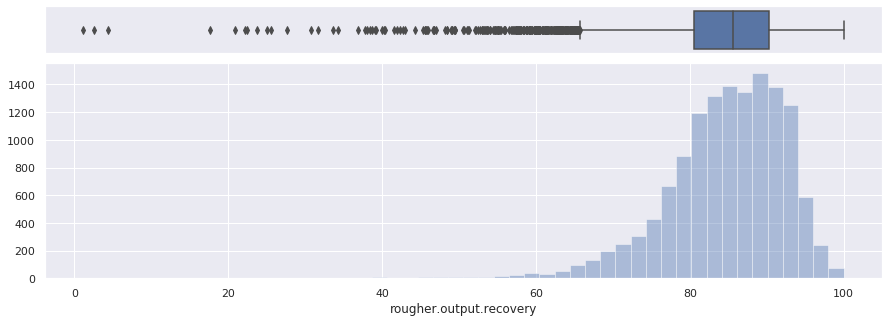


Размер обучающей выборки сократился на 11.00%


In [183]:
len_before = len(train)
train_rougher = train[rougher_features].dropna()
column_info(train_rougher, 'rougher.output.recovery', quantitative=True)
print('Размер обучающей выборки сократился на {:.2%}'.format(1 - (len(train_rougher) / len_before)))

Разделяем выборку на обучающие и целевые признаки.

In [184]:
train_rougher_features = train_rougher.drop('rougher.output.recovery', axis=1)
train_rougher_target = train_rougher['rougher.output.recovery']

Проделываем всё тоже самое с выборкой `test`.


*** Информация по столбцу rougher.output.recovery ***

Тип данных столбца rougher.output.recovery: float64:
В столбце rougher.output.recovery пропущено 0 из 5111 строк, что составляет 0.00%
Минимальное значение: 0.99
Максимальное значение: 99.17
Среднее значение: 86.67
Медианное значение: 87.47


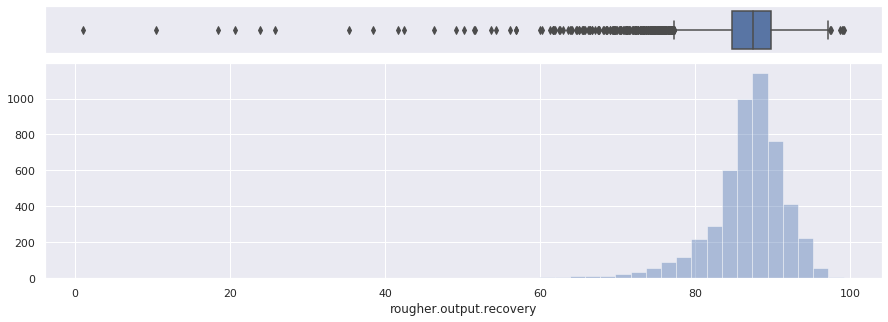


Размер обучающей выборки сократился на 3.16%


In [185]:
len_before = len(test)
test_rougher = test[rougher_features].dropna()
column_info(test_rougher, 'rougher.output.recovery', quantitative=True)
print('Размер обучающей выборки сократился на {:.2%}'.format(1 - (len(test_rougher) / len_before)))

In [186]:
test_rougher_features = test_rougher.drop('rougher.output.recovery', axis=1)
test_rougher_target = test_rougher['rougher.output.recovery']

### 3.2 Поиск оптимальной модели <a id='the_destination03.2'></a>

Функция sMAPE считает соответствующую бизнес метрику. Затем создаём scorer. В силу устройтва метрики чем меньше - тем лучше, указываем это в параметрах.

In [187]:
def sMAPE(original, predicted):
    sum = 0
    for i in range(len(original)):
        sum += abs(original[i] - predicted[i]) / (abs(original[i]) + abs(predicted[i]))
    return 2 * sum / len(original)

sMAPE_scorer = make_scorer(sMAPE, greater_is_better=False)

Приведём все переменные к одному масштабу, для некоторых моделей это существенно.

In [188]:
scaler = StandardScaler()
scaler.fit(train_rougher_features)

train_rougher_features = scaler.transform(train_rougher_features)
test_rougher_features = scaler.transform(test_rougher_features)

Попробуем метод градиентного бустинга. С помощью GridSearchCV найдём подходящие гиперпараметры. Последние буквы в названии CV обозначают, что используется метод кросс-валидации для проверки.

In [189]:
clf_rougher = GradientBoostingRegressor(random_state=state)

parameters = {'learning_rate': [0.01, 0.1, 0.25, 0.5],              
              'n_estimators': [40, 50, 60, 70],
              'max_depth': [3, 4, 5]
              }

grid_clf_rougher = GridSearchCV(estimator=clf_rougher, param_grid = parameters, cv=3, scoring=sMAPE_scorer)
grid_clf_rougher.fit(train_rougher_features, train_rougher_target)

print('Лучший scoring среди всех параметров:', grid_clf_rougher.best_score_)
print('Лучшие параметры:', grid_clf_rougher.best_params_)

Лучший scoring среди всех параметров: -0.0819498567492214
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 40}


Обучаем clf-модель с лучшими параметрами и смотрим на её результаты.

In [190]:
clf_rougher = GradientBoostingRegressor(learning_rate=0.1,
                                        max_depth=3,
                                        n_estimators=40,
                                        random_state=state
                                        )

clf_rougher.fit(train_rougher_features, train_rougher_target)
test_rougher_predictions = clf_rougher.predict(test_rougher_features)
sMAPE_rougher_clf = sMAPE(test_rougher_target, test_rougher_predictions)
print('sMAPE clf на обучающей выборке:', sMAPE(train_rougher_target, clf_rougher.predict(train_rougher_features)))
print('sMAPE clf на тестовой выборке:', sMAPE_rougher_clf)

sMAPE clf на обучающей выборке: 0.043845804928085076
sMAPE clf на тестовой выборке: 0.04174615031661829


Попробум в качестве альтернативы Kernelized Support Vector Machines и посмотрим, какое именно ядро лучше всего справляется с нашей задачей.

In [191]:
svr_rougher = SVR(gamma='auto')

parameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

grid_svr_rougher = GridSearchCV(estimator=svr_rougher, param_grid = parameters, cv=3, scoring=sMAPE_scorer)
grid_svr_rougher.fit(train_rougher_features, train_rougher_target)

print('Лучший scoring среди всех параметров:', grid_svr_rougher.best_score_)
print('Лучшие параметры:', grid_svr_rougher.best_params_)

Лучший scoring среди всех параметров: -0.08047445689824538
Лучшие параметры: {'kernel': 'rbf'}


Выбираем ядро `rbf`. Подбираем гиперпараметры именно для этого ядра. Его не включаем в гиперпараметры, так как вычислительные ресурсы ограничены.

In [192]:
svr_rougher = SVR(kernel='rbf')

parameters = {'gamma': [0.01, 0.1, 1, 10],
              'C': [0.01, 0.1, 1, 10]
              }

grid_svr_rougher = GridSearchCV(estimator=svr_rougher, param_grid = parameters, cv=3, scoring=sMAPE_scorer)
grid_svr_rougher.fit(train_rougher_features, train_rougher_target)

print('Лучший scoring среди всех параметров:', grid_svr_rougher.best_score_)
print('Лучшие параметры:', grid_svr_rougher.best_params_)

Лучший scoring среди всех параметров: -0.07780771684166307
Лучшие параметры: {'C': 0.1, 'gamma': 0.1}


Обучаем svr-модель с лучшими параметрами и смотрим на её результаты.

In [193]:
svr_rougher = SVR(kernel='rbf',
                  C=0.1,
                  gamma=0.1
                  )

svr_rougher.fit(train_rougher_features, train_rougher_target)
test_rougher_predictions = svr_rougher.predict(test_rougher_features)
sMAPE_rougher_svr = sMAPE(test_rougher_target, test_rougher_predictions)
print('sMAPE svr на обучающей выборке:', sMAPE(train_rougher_target, svr_rougher.predict(train_rougher_features)))
print('sMAPE значение svr на тестовой выборке:', sMAPE_rougher_svr)

sMAPE svr на обучающей выборке: 0.045850940055865104
sMAPE значение svr на тестовой выборке: 0.03944487924876587


Проверям модель на адекватность с помощью `DummyRegressor` c параметром `strategy='median'` (в данном случае он лучше).

In [194]:
dummy_rougher = DummyRegressor(strategy='median')

dummy_rougher.fit(train_rougher_features, train_rougher_target)
sMAPE_rougher_dummy = sMAPE(test_rougher_target, dummy_rougher.predict(test_rougher_features))
print('sMAPE значение dummy на тестовой выборке:', sMAPE_rougher_dummy)

sMAPE значение dummy на тестовой выборке: 0.04764499921155196


Собираем все результаты воедино.

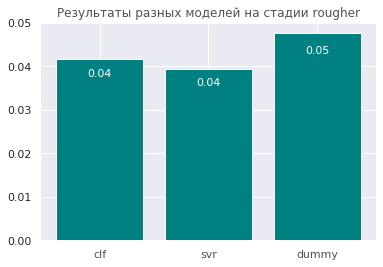

In [195]:
bar_chart([sMAPE_rougher_clf, sMAPE_rougher_svr, sMAPE_rougher_dummy], 
          ['clf', 'svr', 'dummy'], 
          'Результаты разных моделей на стадии rougher'
         )

**Вывод** svr-модель победила, её результат `sMAPE_rougher_svr` будем учитывать в финальной метрике.

## 4. Прогноз final.recovery <a id='the_destination04'></a>

### 4.1 Подготовка данных <a id='the_destination04.1'></a>

Делаем всё тоже самое, что и для случая rougher.

In [196]:
final_independent_features = not_very_correlated_features(train[features_var], 0.9)
final_independent_features

Количество обучающих признаков с корреляций меньше 0.9: 28
Мы сократили количество признаков на 46.15%


['primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_d_air',
 'primary_cleaner.state.floatbank8_d_level',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank11_sulfate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'secondary_cleaner.state.floatbank3_a_air',
 'secondary_cleaner.state.floatbank3_a_level',
 'secondary_cleaner.state.floatbank3_b_air',
 'secondary_cleaner.state.floatbank3_b_level',
 'secondary_cleaner.state.floatbank4_a_air',
 'secondary_cleaner.state.floatbank4_a_level',
 'secondary_cleaner.state.floatbank4_b_air',
 'secondary_cleaner.state.floatbank4_b_level',
 'secondary_cleaner.state.floatbank5_a_air',
 'secondary_cleaner.state.floatbank5_b_air',
 

In [197]:
final_features = final_independent_features
final_features.append('final.output.recovery')


*** Информация по столбцу final.output.recovery ***

Тип данных столбца final.output.recovery: float64:
В столбце final.output.recovery пропущено 0 из 13978 строк, что составляет 0.00%
Минимальное значение: 0.09
Максимальное значение: 100.00
Среднее значение: 67.12
Медианное значение: 67.63


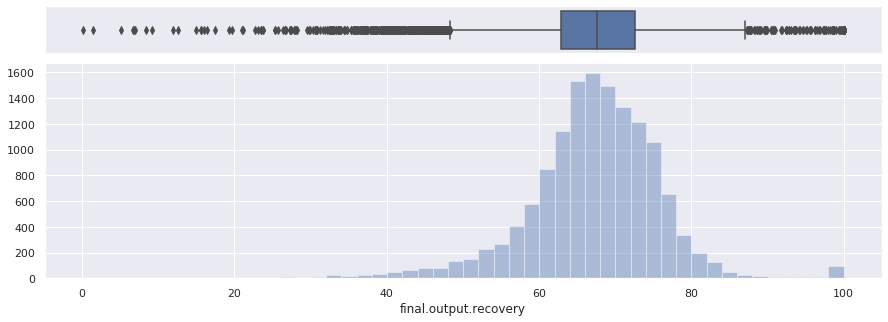


Размер обучающей выборки сократился на 7.50%


In [198]:
len_before = len(train)
train_final = train[final_features].dropna()
column_info(train_final, 'final.output.recovery', quantitative=True)
print('Размер обучающей выборки сократился на {:.2%}'.format(1 - (len(train_final) / len_before)))

In [199]:
train_final_features = train_final.drop('final.output.recovery', axis=1)
train_final_target = train_final['final.output.recovery']


*** Информация по столбцу final.output.recovery ***

Тип данных столбца final.output.recovery: float64:
В столбце final.output.recovery пропущено 0 из 5182 строк, что составляет 0.00%
Минимальное значение: 2.03
Максимальное значение: 100.00
Среднее значение: 69.10
Медианное значение: 69.96


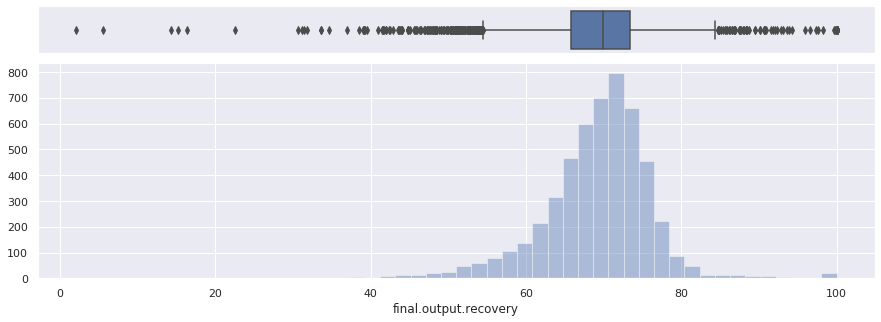


Размер обучающей выборки сократился на 1.82%


In [200]:
len_before = len(test)
test_final = test[final_features].dropna()
column_info(test_final, 'final.output.recovery', quantitative=True)
print('Размер обучающей выборки сократился на {:.2%}'.format(1 - (len(test_final) / len_before)))

In [201]:
test_final_features = test_final.drop('final.output.recovery', axis=1)
test_final_target = test_final['final.output.recovery']

### 4.2 Поиск оптимальной модели <a id='the_destination04.2'></a>

In [124]:
scaler = StandardScaler()
scaler.fit(train_final_features)

train_final_features = scaler.transform(train_final_features)
test_final_features = scaler.transform(test_final_features)

In [125]:
clf_final = GradientBoostingRegressor(random_state=state)

parameters = {'learning_rate': [0.01, 0.1, 0.25, 0.5],              
              'n_estimators': [40, 50, 60, 70],
              'max_depth': [3, 4, 5]
              }

grid_clf_final = GridSearchCV(estimator=clf_final, param_grid = parameters, cv=3, scoring=sMAPE_scorer)
grid_clf_final.fit(train_final_features, train_final_target)

print('Лучший scoring среди всех параметров:', grid_clf_final.best_score_)
print('Лучшие параметры:', grid_clf_final.best_params_)

Лучший scoring среди всех параметров: -0.1031110390392229
Лучшие параметры: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 70}


In [126]:
clf_final = GradientBoostingRegressor(learning_rate=0.01,
                                        max_depth=5,
                                        n_estimators=70,
                                        random_state=state
                                       )

clf_final.fit(train_final_features, train_final_target)
test_final_predictions = clf_final.predict(test_final_features)

sMAPE_final_clf = sMAPE(test_final_target, test_final_predictions)
print('sMAPE clf на обучающей выборке:', sMAPE(train_final_target, clf_final.predict(train_final_features)))
print('sMAPE clf на тестовой выборке:', sMAPE_final_clf)

sMAPE clf на обучающей выборке: 0.08099219959261024
sMAPE clf на тестовой выборке: 0.07572501786852746


In [127]:
svr_final = SVR(kernel='rbf')

parameters = {'gamma': [0.01, 0.1, 1, 10],
              'C': [0.1, 1, 10, 100]
              }

grid_svr_final = GridSearchCV(estimator=svr_final, param_grid = parameters, cv=3, scoring=sMAPE_scorer)
grid_svr_final.fit(train_final_features, train_final_target)

print('Лучший scoring среди всех параметров:', grid_svr_final.best_score_)
print('Лучшие параметры:', grid_svr_final.best_params_)

Лучший scoring среди всех параметров: -0.1036179173850702
Лучшие параметры: {'C': 0.1, 'gamma': 0.01}


In [128]:
svr_final = SVR(kernel='rbf',
                  C=0.1,
                  gamma=0.01
                  )

svr_final.fit(train_final_features, train_final_target)
test_final_predictions = svr_final.predict(test_final_features)

sMAPE_final_svr = sMAPE(test_final_target, test_final_predictions)
print('sMAPE svr на обучающей выборке:', sMAPE(train_final_target, svr_final.predict(train_final_features)))
print('sMAPE svr на тестовой выборке:', sMAPE_final_svr)

sMAPE svr на обучающей выборке: 0.07921211550385307
sMAPE svr на тестовой выборке: 0.07209739130619343


In [129]:
dummy_final = DummyRegressor(strategy='median')

dummy_final.fit(train_final_features, train_final_target)
sMAPE_final_dummy = sMAPE(test_final_target, dummy_final.predict(test_final_features))
print('sMAPE dummy на обучающей выборке:', sMAPE(train_final_target, dummy_final.predict(train_final_features)))
print('sMAPE dummy на тестовой выборке:', sMAPE_final_dummy)

sMAPE dummy на обучающей выборке: 0.09898676578134195
sMAPE dummy на тестовой выборке: 0.0815680180604258


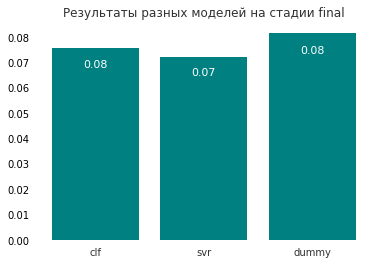

In [130]:
bar_chart([sMAPE_final_clf, sMAPE_final_svr, sMAPE_final_dummy], 
          ['clf', 'svr', 'dummy'], 
          'Результаты разных моделей на стадии final'
         )

**Вывод** svr-модель опять победила, её результат `sMAPE_final_svr` будем учитывать в финальной метрике.

# 5. Вывод <a id='the_destination05'></a>

In [131]:
sMAPE_combined_svr = sMAPE_rougher_svr * 0.25 + sMAPE_final_svr * 0.75
sMAPE_combined_clf = sMAPE_rougher_clf * 0.25 + sMAPE_final_clf * 0.75
sMAPE_combined_dummy = sMAPE_rougher_dummy * 0.25 + sMAPE_final_dummy * 0.75

print('Результат работы svr-модели:', sMAPE_combined_svr)
print('Результат работы clf-модели:', sMAPE_combined_clf)
print('Результат работы dummy-модели:', sMAPE_combined_dummy)
print('Результат svr-модели лучше результата dummy-модели на {:.2%}'.format(sMAPE_combined_dummy / sMAPE_combined_svr - 1))

Результат работы svr-модели: 0.06393426329183655
Результат работы clf-модели: 0.06723030098055016
Результат работы dummy-модели: 0.07308726334820734
Результат svr-модели лучше результата dummy-модели на 14.32%


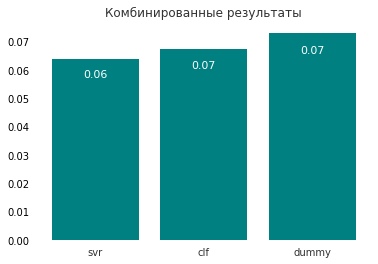

In [132]:
bar_chart([sMAPE_combined_svr, sMAPE_combined_clf, sMAPE_combined_dummy], ['svr', 'clf', 'dummy'], 'Комбинированные результаты')

Модель Kernelized Support Vector Machines с ядром rbf способна предсказывает бизнес-метрику recovery на разных стадиях процесса и оказалась эффективнее градиентного бустинга и модели, которая всё время предсказывает медианное значение.